# Data Loading

In [ ]:
!pip install piqa

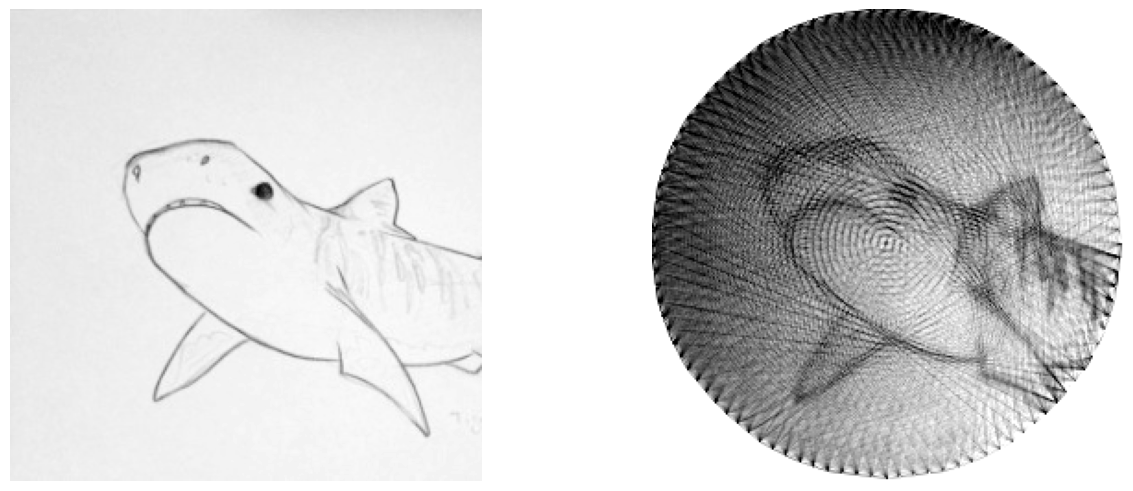

In [13]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor
from typing import Tuple


class Config:
    DATASET_DIR = "/kaggle/input/stringart-ai-1000/stringart-dataset"
    UNET_PLOT_DIR= "/kaggle/working"
    

class StringArtDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

        self.images = []
        self.labels = []

        for img_path, label_path in self.file_list:
            img = np.array(imread(img_path))
            label = np.array(imread(label_path))

            self.images.append(to_tensor(img))
            self.labels.append(to_tensor(label))

        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def load_data(input_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Load the dataset from the specified directory, split it into training, validation, and test sets,
    and return corresponding DataLoaders for each set.

    Parameters
    ----------
    input_dir : str
        The directory path containing the dataset. It should have a `metadata.csv` file and
        subdirectories `images` and `labels` containing the image and label files, respectively.
    batch_size : int, optional
        The batch size for the DataLoader. Default is 64.

    Returns
    -------
    tuple
        A tuple containing three `DataLoader` objects:
        - train_loader (DataLoader): The DataLoader for the training dataset.
        - validation_loader (DataLoader): The DataLoader for the validation dataset.
        - test_loader (DataLoader): The DataLoader for the test dataset.
    """

    df = pd.read_csv(os.path.join(input_dir, "metadata.csv"))
    samples = [
        (os.path.join(input_dir, "images", img_name), os.path.join(input_dir, "labels", label_name))
        for _, (img_name, label_name) in df.iterrows()
    ]

    train_data, temp_data = train_test_split(samples, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.1, random_state=42)

    train_loader = DataLoader(StringArtDataset(train_data), batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(StringArtDataset(validation_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StringArtDataset(test_data), batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader



train_loader, validation_loader, test_loader = load_data(Config.DATASET_DIR, batch_size=16)

batch = next(iter(train_loader))
img, label = batch[0][0], batch[1][0]

image = img.cpu().numpy().transpose(1, 2, 0)
label = label.cpu().numpy().transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=[2 * 6.4, 4.8], constrained_layout=True)
cmap = "gray"

axs[0].imshow(image, cmap=cmap)
axs[0].set_axis_off()

axs[1].imshow(label, cmap=cmap)
axs[1].set_axis_off()

fig.show()


In [6]:
import torch
from torch import nn, optim

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()

        self.double_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv2d(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList(
            [
                DoubleConv2d(in_channels, 16),
                DoubleConv2d(16, 32),
                DoubleConv2d(32, 64),
                DoubleConv2d(64, 128),
                DoubleConv2d(128, 256),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                DoubleConv2d(256, 128),
                DoubleConv2d(128, 64),
                DoubleConv2d(64, 32),
                DoubleConv2d(32, 16),
            ]
        )

        self.deconv = nn.ModuleList(
            [
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            ]
        )

        self.pool = nn.MaxPool2d((2, 2))
        self.last_layer_conv = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        stk = []
        for encoder in self.encoder:
            x = encoder(x)
            stk.append(x)
            x = self.pool(x)

        x = stk.pop(-1)
        for index in range(len(self.decoder)):
            encoder_output = stk.pop(-1)
            x = self.deconv[index](x)

            x = torch.cat([encoder_output, x], dim=1)
            x = self.decoder[index](x)

        return torch.sigmoid(self.last_layer_conv(x))

# Training Functions

In [10]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os


def train(model, train_loader: DataLoader, val_loader: DataLoader, criterion, optimizer, epochs: int, accumulation_steps: int = 4, device=None, scheduler=None):
    """Train a PyTorch model and validate it after each epoch.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained.
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    criterion : torch.nn.Module
        The loss function to be used during training.
    optimizer : torch.optim.Optimizer
        The optimizer to update the model's parameters.
    epochs : int
        The number of epochs for training.
    device : torch.device, optional
        The device on which to run the model (CPU or CUDA). If None, the function will automatically choose the device.
    scheduler : optim.lr_scheduler, optional
        The scheduler method for the learning rate. If None, constant learning rate is used.

    Returns
    -------
    tuple
        A tuple containing two lists:
            - train_loss_history (list): List of training loss values at each epoch.
            - val_loss_history (list): List of validation loss values at each epoch.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 30)

        # training phase
        model.train()
        running_train_loss = 0.0

        for index, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            if (index + 1) % accumulation_steps == 0 or (index + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        # validation Phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f}", end=" | ")
        print(f"Val   Loss: {epoch_val_loss:.4f}")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.8f}")

        if scheduler:
            scheduler.step()


    return train_loss_history, val_loss_history


def plot_loss(train_loss, val_loss):
    """Plot the training and validation loss over epochs.

    Parameters
    ----------
    train_loss : list
        List of training loss values for each epoch.
    val_loss : list
        List of validation loss values for each epoch.

    Returns
    -------
    None
        This function does not return any value. It directly displays the plot.
    """

    plt.title("Training & Validation Loss")
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(Config.UNET_PLOT_DIR, "loss.png"))
    plt.show()


def plot_test_results(model, test_loader, device, num_images=5):
    """Plot a set of test results, displaying input images, predicted outputs, and ground truth labels.

    Parameters
    ----------
    model : torch.nn.Module
       The trained model used to generate predictions.
    test_loader : torch.utils.data.DataLoader
       DataLoader for the test dataset.
    device : torch.device
       The device on which the model is running (CPU or CUDA).
    num_images : int, optional
       The number of images to display. Default is 5.

    Returns
    -------
    None
       This function does not return any value. It directly displays the plot.
    """

    model.eval()

    with torch.no_grad():
        # get first batch
        sample_inputs, sample_labels = next(iter(test_loader))
        sample_inputs, sample_labels = sample_inputs.to(device), sample_labels.to(device)

        # get model outputs
        sample_outputs = model(sample_inputs)

        # number of images to display
        batch_size = sample_inputs.size(0)
        num_images = min(num_images, batch_size)

        fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
        for i in range(num_images):
            # input
            axes[i, 0].imshow(sample_inputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 0].set_title(f"Input Image {i + 1}")
            axes[i, 0].axis("off")

            # predicted
            axes[i, 1].imshow(sample_outputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 1].set_title(f"Predicted Image {i + 1}")
            axes[i, 1].axis("off")

            # ground truth
            axes[i, 2].imshow(sample_labels[i].cpu().squeeze(0), cmap="gray")
            axes[i, 2].set_title(f"Ground Truth {i + 1}")
            axes[i, 2].axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(Config.UNET_PLOT_DIR, "test.png"))
        plt.show()

# Training


Epoch 1/300
------------------------------


Train Loss: 0.7815 | Val   Loss: 0.7432
Learning Rate: 0.00010000

Epoch 2/300
------------------------------


Train Loss: 0.7420 | Val   Loss: 0.7330
Learning Rate: 0.00009970

Epoch 3/300
------------------------------


Train Loss: 0.7233 | Val   Loss: 0.7184
Learning Rate: 0.00009940

Epoch 4/300
------------------------------


Train Loss: 0.7133 | Val   Loss: 0.7109
Learning Rate: 0.00009910

Epoch 5/300
------------------------------


Train Loss: 0.7067 | Val   Loss: 0.7056
Learning Rate: 0.00009880

Epoch 6/300
------------------------------


Train Loss: 0.7022 | Val   Loss: 0.7014
Learning Rate: 0.00009850

Epoch 7/300
------------------------------


Train Loss: 0.6988 | Val   Loss: 0.6991
Learning Rate: 0.00009820

Epoch 8/300
------------------------------


Train Loss: 0.6953 | Val   Loss: 0.6962
Learning Rate: 0.00009790

Epoch 9/300
------------------------------


Train Loss: 0.6928 | Val   Loss: 0.6936
Learning Rate: 0.00009760

Epoch 10/300
------------------------------


Train Loss: 0.6903 | Val   Loss: 0.6915
Learning Rate: 0.00009730

Epoch 11/300
------------------------------


Train Loss: 0.6884 | Val   Loss: 0.6899
Learning Rate: 0.00009700

Epoch 12/300
------------------------------


Train Loss: 0.6866 | Val   Loss: 0.6884
Learning Rate: 0.00009670

Epoch 13/300
------------------------------


Train Loss: 0.6849 | Val   Loss: 0.6867
Learning Rate: 0.00009640

Epoch 14/300
------------------------------


Train Loss: 0.6834 | Val   Loss: 0.6850
Learning Rate: 0.00009610

Epoch 15/300
------------------------------


Train Loss: 0.6818 | Val   Loss: 0.6839
Learning Rate: 0.00009580

Epoch 16/300
------------------------------


Train Loss: 0.6806 | Val   Loss: 0.6822
Learning Rate: 0.00009550

Epoch 17/300
------------------------------


Train Loss: 0.6795 | Val   Loss: 0.6812
Learning Rate: 0.00009520

Epoch 18/300
------------------------------


Train Loss: 0.6784 | Val   Loss: 0.6810
Learning Rate: 0.00009490

Epoch 19/300
------------------------------


Train Loss: 0.6767 | Val   Loss: 0.6801
Learning Rate: 0.00009460

Epoch 20/300
------------------------------


Train Loss: 0.6757 | Val   Loss: 0.6790
Learning Rate: 0.00009430

Epoch 21/300
------------------------------


Train Loss: 0.6746 | Val   Loss: 0.6758
Learning Rate: 0.00009400

Epoch 22/300
------------------------------


Train Loss: 0.6736 | Val   Loss: 0.6759
Learning Rate: 0.00009370

Epoch 23/300
------------------------------


Train Loss: 0.6725 | Val   Loss: 0.6750
Learning Rate: 0.00009340

Epoch 24/300
------------------------------


Train Loss: 0.6717 | Val   Loss: 0.6737
Learning Rate: 0.00009310

Epoch 25/300
------------------------------


Train Loss: 0.6704 | Val   Loss: 0.6718
Learning Rate: 0.00009280

Epoch 26/300
------------------------------


Train Loss: 0.6695 | Val   Loss: 0.6715
Learning Rate: 0.00009250

Epoch 27/300
------------------------------


Train Loss: 0.6677 | Val   Loss: 0.6674
Learning Rate: 0.00009220

Epoch 28/300
------------------------------


Train Loss: 0.6663 | Val   Loss: 0.6686
Learning Rate: 0.00009190

Epoch 29/300
------------------------------


Train Loss: 0.6647 | Val   Loss: 0.6663
Learning Rate: 0.00009160

Epoch 30/300
------------------------------


Train Loss: 0.6642 | Val   Loss: 0.6648
Learning Rate: 0.00009130

Epoch 31/300
------------------------------


Train Loss: 0.6624 | Val   Loss: 0.6650
Learning Rate: 0.00009100

Epoch 32/300
------------------------------


Train Loss: 0.6614 | Val   Loss: 0.6623
Learning Rate: 0.00009070

Epoch 33/300
------------------------------


Train Loss: 0.6590 | Val   Loss: 0.6596
Learning Rate: 0.00009040

Epoch 34/300
------------------------------


Train Loss: 0.6564 | Val   Loss: 0.6570
Learning Rate: 0.00009010

Epoch 35/300
------------------------------


Train Loss: 0.6550 | Val   Loss: 0.6550
Learning Rate: 0.00008980

Epoch 36/300
------------------------------


Train Loss: 0.6527 | Val   Loss: 0.6532
Learning Rate: 0.00008950

Epoch 37/300
------------------------------


Train Loss: 0.6510 | Val   Loss: 0.6548
Learning Rate: 0.00008920

Epoch 38/300
------------------------------


Train Loss: 0.6484 | Val   Loss: 0.6467
Learning Rate: 0.00008890

Epoch 39/300
------------------------------


Train Loss: 0.6464 | Val   Loss: 0.6485
Learning Rate: 0.00008860

Epoch 40/300
------------------------------


Train Loss: 0.6420 | Val   Loss: 0.6410
Learning Rate: 0.00008830

Epoch 41/300
------------------------------


Train Loss: 0.6359 | Val   Loss: 0.6345
Learning Rate: 0.00008800

Epoch 42/300
------------------------------


Train Loss: 0.6325 | Val   Loss: 0.6336
Learning Rate: 0.00008770

Epoch 43/300
------------------------------


Train Loss: 0.6306 | Val   Loss: 0.6294
Learning Rate: 0.00008740

Epoch 44/300
------------------------------


Train Loss: 0.6261 | Val   Loss: 0.6249
Learning Rate: 0.00008710

Epoch 45/300
------------------------------


Train Loss: 0.6231 | Val   Loss: 0.6215
Learning Rate: 0.00008680

Epoch 46/300
------------------------------


Train Loss: 0.6177 | Val   Loss: 0.6176
Learning Rate: 0.00008650

Epoch 47/300
------------------------------


Train Loss: 0.6162 | Val   Loss: 0.6194
Learning Rate: 0.00008620

Epoch 48/300
------------------------------


Train Loss: 0.6140 | Val   Loss: 0.6162
Learning Rate: 0.00008590

Epoch 49/300
------------------------------


Train Loss: 0.6122 | Val   Loss: 0.6145
Learning Rate: 0.00008560

Epoch 50/300
------------------------------


Train Loss: 0.6113 | Val   Loss: 0.6148
Learning Rate: 0.00008530

Epoch 51/300
------------------------------


Train Loss: 0.6100 | Val   Loss: 0.6095
Learning Rate: 0.00008500

Epoch 52/300
------------------------------


Train Loss: 0.6065 | Val   Loss: 0.6058
Learning Rate: 0.00008470

Epoch 53/300
------------------------------


Train Loss: 0.6044 | Val   Loss: 0.6073
Learning Rate: 0.00008440

Epoch 54/300
------------------------------


Train Loss: 0.6031 | Val   Loss: 0.6050
Learning Rate: 0.00008410

Epoch 55/300
------------------------------


Train Loss: 0.6028 | Val   Loss: 0.6061
Learning Rate: 0.00008380

Epoch 56/300
------------------------------


Train Loss: 0.6011 | Val   Loss: 0.6026
Learning Rate: 0.00008350

Epoch 57/300
------------------------------


Train Loss: 0.6000 | Val   Loss: 0.6002
Learning Rate: 0.00008320

Epoch 58/300
------------------------------


Train Loss: 0.5991 | Val   Loss: 0.5987
Learning Rate: 0.00008290

Epoch 59/300
------------------------------


Train Loss: 0.5985 | Val   Loss: 0.5987
Learning Rate: 0.00008260

Epoch 60/300
------------------------------


Train Loss: 0.5962 | Val   Loss: 0.5973
Learning Rate: 0.00008230

Epoch 61/300
------------------------------


Train Loss: 0.5975 | Val   Loss: 0.6057
Learning Rate: 0.00008200

Epoch 62/300
------------------------------


Train Loss: 0.5962 | Val   Loss: 0.5980
Learning Rate: 0.00008170

Epoch 63/300
------------------------------


Train Loss: 0.5942 | Val   Loss: 0.5968
Learning Rate: 0.00008140

Epoch 64/300
------------------------------


Train Loss: 0.5948 | Val   Loss: 0.5960
Learning Rate: 0.00008110

Epoch 65/300
------------------------------


Train Loss: 0.5928 | Val   Loss: 0.5959
Learning Rate: 0.00008080

Epoch 66/300
------------------------------


Train Loss: 0.5933 | Val   Loss: 0.5980
Learning Rate: 0.00008050

Epoch 67/300
------------------------------


Train Loss: 0.5917 | Val   Loss: 0.5913
Learning Rate: 0.00008020

Epoch 68/300
------------------------------


Train Loss: 0.5903 | Val   Loss: 0.5920
Learning Rate: 0.00007990

Epoch 69/300
------------------------------


Train Loss: 0.5894 | Val   Loss: 0.5896
Learning Rate: 0.00007960

Epoch 70/300
------------------------------


Train Loss: 0.5895 | Val   Loss: 0.5895
Learning Rate: 0.00007930

Epoch 71/300
------------------------------


Train Loss: 0.5899 | Val   Loss: 0.6083
Learning Rate: 0.00007900

Epoch 72/300
------------------------------


Train Loss: 0.5922 | Val   Loss: 0.5958
Learning Rate: 0.00007870

Epoch 73/300
------------------------------


Train Loss: 0.5920 | Val   Loss: 0.5926
Learning Rate: 0.00007840

Epoch 74/300
------------------------------


Train Loss: 0.5897 | Val   Loss: 0.5957
Learning Rate: 0.00007810

Epoch 75/300
------------------------------


Train Loss: 0.5888 | Val   Loss: 0.5889
Learning Rate: 0.00007780

Epoch 76/300
------------------------------


Train Loss: 0.5865 | Val   Loss: 0.5875
Learning Rate: 0.00007750

Epoch 77/300
------------------------------


Train Loss: 0.5859 | Val   Loss: 0.5860
Learning Rate: 0.00007720

Epoch 78/300
------------------------------


Train Loss: 0.5848 | Val   Loss: 0.5879
Learning Rate: 0.00007690

Epoch 79/300
------------------------------


Train Loss: 0.5841 | Val   Loss: 0.5862
Learning Rate: 0.00007660

Epoch 80/300
------------------------------


Train Loss: 0.5840 | Val   Loss: 0.5868
Learning Rate: 0.00007630

Epoch 81/300
------------------------------


Train Loss: 0.5844 | Val   Loss: 0.5865
Learning Rate: 0.00007600

Epoch 82/300
------------------------------


Train Loss: 0.5835 | Val   Loss: 0.5872
Learning Rate: 0.00007570

Epoch 83/300
------------------------------


Train Loss: 0.5818 | Val   Loss: 0.5829
Learning Rate: 0.00007540

Epoch 84/300
------------------------------


Train Loss: 0.5819 | Val   Loss: 0.5838
Learning Rate: 0.00007510

Epoch 85/300
------------------------------


Train Loss: 0.5805 | Val   Loss: 0.5844
Learning Rate: 0.00007480

Epoch 86/300
------------------------------


Train Loss: 0.5819 | Val   Loss: 0.5868
Learning Rate: 0.00007450

Epoch 87/300
------------------------------


Train Loss: 0.5826 | Val   Loss: 0.5840
Learning Rate: 0.00007420

Epoch 88/300
------------------------------


Train Loss: 0.5807 | Val   Loss: 0.5829
Learning Rate: 0.00007390

Epoch 89/300
------------------------------


Train Loss: 0.5814 | Val   Loss: 0.5825
Learning Rate: 0.00007360

Epoch 90/300
------------------------------


Train Loss: 0.5797 | Val   Loss: 0.5852
Learning Rate: 0.00007330

Epoch 91/300
------------------------------


Train Loss: 0.5795 | Val   Loss: 0.5808
Learning Rate: 0.00007300

Epoch 92/300
------------------------------


Train Loss: 0.5781 | Val   Loss: 0.5838
Learning Rate: 0.00007270

Epoch 93/300
------------------------------


Train Loss: 0.5784 | Val   Loss: 0.5831
Learning Rate: 0.00007240

Epoch 94/300
------------------------------


Train Loss: 0.5781 | Val   Loss: 0.5829
Learning Rate: 0.00007210

Epoch 95/300
------------------------------


Train Loss: 0.5779 | Val   Loss: 0.5797
Learning Rate: 0.00007180

Epoch 96/300
------------------------------


Train Loss: 0.5770 | Val   Loss: 0.5800
Learning Rate: 0.00007150

Epoch 97/300
------------------------------


Train Loss: 0.5756 | Val   Loss: 0.5775
Learning Rate: 0.00007120

Epoch 98/300
------------------------------


Train Loss: 0.5748 | Val   Loss: 0.5789
Learning Rate: 0.00007090

Epoch 99/300
------------------------------


Train Loss: 0.5747 | Val   Loss: 0.5792
Learning Rate: 0.00007060

Epoch 100/300
------------------------------


Train Loss: 0.5740 | Val   Loss: 0.5796
Learning Rate: 0.00007030

Epoch 101/300
------------------------------


Train Loss: 0.5729 | Val   Loss: 0.5774
Learning Rate: 0.00007000

Epoch 102/300
------------------------------


Train Loss: 0.5727 | Val   Loss: 0.5790
Learning Rate: 0.00006970

Epoch 103/300
------------------------------


Train Loss: 0.5720 | Val   Loss: 0.5761
Learning Rate: 0.00006940

Epoch 104/300
------------------------------


Train Loss: 0.5729 | Val   Loss: 0.5840
Learning Rate: 0.00006910

Epoch 105/300
------------------------------


Train Loss: 0.5751 | Val   Loss: 0.5814
Learning Rate: 0.00006880

Epoch 106/300
------------------------------


Train Loss: 0.5745 | Val   Loss: 0.5786
Learning Rate: 0.00006850

Epoch 107/300
------------------------------


Train Loss: 0.5734 | Val   Loss: 0.5778
Learning Rate: 0.00006820

Epoch 108/300
------------------------------


Train Loss: 0.5718 | Val   Loss: 0.5758
Learning Rate: 0.00006790

Epoch 109/300
------------------------------


Train Loss: 0.5713 | Val   Loss: 0.5756
Learning Rate: 0.00006760

Epoch 110/300
------------------------------


Train Loss: 0.5697 | Val   Loss: 0.5741
Learning Rate: 0.00006730

Epoch 111/300
------------------------------


Train Loss: 0.5696 | Val   Loss: 0.5745
Learning Rate: 0.00006700

Epoch 112/300
------------------------------


Train Loss: 0.5691 | Val   Loss: 0.5776
Learning Rate: 0.00006670

Epoch 113/300
------------------------------


Train Loss: 0.5680 | Val   Loss: 0.5745
Learning Rate: 0.00006640

Epoch 114/300
------------------------------


Train Loss: 0.5675 | Val   Loss: 0.5728
Learning Rate: 0.00006610

Epoch 115/300
------------------------------


Train Loss: 0.5678 | Val   Loss: 0.5723
Learning Rate: 0.00006580

Epoch 116/300
------------------------------


Train Loss: 0.5672 | Val   Loss: 0.5732
Learning Rate: 0.00006550

Epoch 117/300
------------------------------


Train Loss: 0.5663 | Val   Loss: 0.5736
Learning Rate: 0.00006520

Epoch 118/300
------------------------------


Train Loss: 0.5660 | Val   Loss: 0.5729
Learning Rate: 0.00006490

Epoch 119/300
------------------------------


Train Loss: 0.5650 | Val   Loss: 0.5716
Learning Rate: 0.00006460

Epoch 120/300
------------------------------


Train Loss: 0.5645 | Val   Loss: 0.5720
Learning Rate: 0.00006430

Epoch 121/300
------------------------------


Train Loss: 0.5636 | Val   Loss: 0.5715
Learning Rate: 0.00006400

Epoch 122/300
------------------------------


Train Loss: 0.5634 | Val   Loss: 0.5718
Learning Rate: 0.00006370

Epoch 123/300
------------------------------


Train Loss: 0.5632 | Val   Loss: 0.5700
Learning Rate: 0.00006340

Epoch 124/300
------------------------------


Train Loss: 0.5628 | Val   Loss: 0.5701
Learning Rate: 0.00006310

Epoch 125/300
------------------------------


Train Loss: 0.5622 | Val   Loss: 0.5754
Learning Rate: 0.00006280

Epoch 126/300
------------------------------


Train Loss: 0.5612 | Val   Loss: 0.5736
Learning Rate: 0.00006250

Epoch 127/300
------------------------------


Train Loss: 0.5604 | Val   Loss: 0.5695
Learning Rate: 0.00006220

Epoch 128/300
------------------------------


Train Loss: 0.5604 | Val   Loss: 0.5683
Learning Rate: 0.00006190

Epoch 129/300
------------------------------


Train Loss: 0.5598 | Val   Loss: 0.5733
Learning Rate: 0.00006160

Epoch 130/300
------------------------------


Train Loss: 0.5589 | Val   Loss: 0.5704
Learning Rate: 0.00006130

Epoch 131/300
------------------------------


Train Loss: 0.5589 | Val   Loss: 0.5683
Learning Rate: 0.00006100

Epoch 132/300
------------------------------


Train Loss: 0.5584 | Val   Loss: 0.5719
Learning Rate: 0.00006070

Epoch 133/300
------------------------------


Train Loss: 0.5583 | Val   Loss: 0.5715
Learning Rate: 0.00006040

Epoch 134/300
------------------------------


Train Loss: 0.5585 | Val   Loss: 0.5692
Learning Rate: 0.00006010

Epoch 135/300
------------------------------


Train Loss: 0.5569 | Val   Loss: 0.5710
Learning Rate: 0.00005980

Epoch 136/300
------------------------------


Train Loss: 0.5566 | Val   Loss: 0.5699
Learning Rate: 0.00005950

Epoch 137/300
------------------------------


Train Loss: 0.5560 | Val   Loss: 0.5705
Learning Rate: 0.00005920

Epoch 138/300
------------------------------


Train Loss: 0.5574 | Val   Loss: 0.5802
Learning Rate: 0.00005890

Epoch 139/300
------------------------------


Train Loss: 0.5593 | Val   Loss: 0.5684
Learning Rate: 0.00005860

Epoch 140/300
------------------------------


Train Loss: 0.5575 | Val   Loss: 0.5671
Learning Rate: 0.00005830

Epoch 141/300
------------------------------


Train Loss: 0.5556 | Val   Loss: 0.5668
Learning Rate: 0.00005800

Epoch 142/300
------------------------------


Train Loss: 0.5542 | Val   Loss: 0.5657
Learning Rate: 0.00005770

Epoch 143/300
------------------------------


Train Loss: 0.5535 | Val   Loss: 0.5655
Learning Rate: 0.00005740

Epoch 144/300
------------------------------


Train Loss: 0.5522 | Val   Loss: 0.5645
Learning Rate: 0.00005710

Epoch 145/300
------------------------------


Train Loss: 0.5521 | Val   Loss: 0.5668
Learning Rate: 0.00005680

Epoch 146/300
------------------------------


Train Loss: 0.5519 | Val   Loss: 0.5651
Learning Rate: 0.00005650

Epoch 147/300
------------------------------


Train Loss: 0.5510 | Val   Loss: 0.5671
Learning Rate: 0.00005620

Epoch 148/300
------------------------------


Train Loss: 0.5504 | Val   Loss: 0.5668
Learning Rate: 0.00005590

Epoch 149/300
------------------------------


Train Loss: 0.5522 | Val   Loss: 0.5691
Learning Rate: 0.00005560

Epoch 150/300
------------------------------


Train Loss: 0.5514 | Val   Loss: 0.5716
Learning Rate: 0.00005530

Epoch 151/300
------------------------------


Train Loss: 0.5543 | Val   Loss: 0.5657
Learning Rate: 0.00005500

Epoch 152/300
------------------------------


Train Loss: 0.5514 | Val   Loss: 0.5636
Learning Rate: 0.00005470

Epoch 153/300
------------------------------


Train Loss: 0.5493 | Val   Loss: 0.5638
Learning Rate: 0.00005440

Epoch 154/300
------------------------------


Train Loss: 0.5486 | Val   Loss: 0.5623
Learning Rate: 0.00005410

Epoch 155/300
------------------------------


Train Loss: 0.5481 | Val   Loss: 0.5624
Learning Rate: 0.00005380

Epoch 156/300
------------------------------


Train Loss: 0.5479 | Val   Loss: 0.5628
Learning Rate: 0.00005350

Epoch 157/300
------------------------------


Train Loss: 0.5464 | Val   Loss: 0.5628
Learning Rate: 0.00005320

Epoch 158/300
------------------------------


Train Loss: 0.5456 | Val   Loss: 0.5638
Learning Rate: 0.00005290

Epoch 159/300
------------------------------


Train Loss: 0.5443 | Val   Loss: 0.5607
Learning Rate: 0.00005260

Epoch 160/300
------------------------------


Train Loss: 0.5439 | Val   Loss: 0.5613
Learning Rate: 0.00005230

Epoch 161/300
------------------------------


Train Loss: 0.5443 | Val   Loss: 0.5614
Learning Rate: 0.00005200

Epoch 162/300
------------------------------


Train Loss: 0.5441 | Val   Loss: 0.5608
Learning Rate: 0.00005170

Epoch 163/300
------------------------------


Train Loss: 0.5440 | Val   Loss: 0.5617
Learning Rate: 0.00005140

Epoch 164/300
------------------------------


Train Loss: 0.5423 | Val   Loss: 0.5610
Learning Rate: 0.00005110

Epoch 165/300
------------------------------


Train Loss: 0.5412 | Val   Loss: 0.5598
Learning Rate: 0.00005080

Epoch 166/300
------------------------------


Train Loss: 0.5421 | Val   Loss: 0.5597
Learning Rate: 0.00005050

Epoch 167/300
------------------------------


Train Loss: 0.5420 | Val   Loss: 0.5599
Learning Rate: 0.00005020

Epoch 168/300
------------------------------


Train Loss: 0.5404 | Val   Loss: 0.5593
Learning Rate: 0.00004990

Epoch 169/300
------------------------------


Train Loss: 0.5389 | Val   Loss: 0.5593
Learning Rate: 0.00004960

Epoch 170/300
------------------------------


Train Loss: 0.5401 | Val   Loss: 0.5599
Learning Rate: 0.00004930

Epoch 171/300
------------------------------


Train Loss: 0.5385 | Val   Loss: 0.5631
Learning Rate: 0.00004900

Epoch 172/300
------------------------------


Train Loss: 0.5393 | Val   Loss: 0.5608
Learning Rate: 0.00004870

Epoch 173/300
------------------------------


Train Loss: 0.5393 | Val   Loss: 0.5604
Learning Rate: 0.00004840

Epoch 174/300
------------------------------


Train Loss: 0.5396 | Val   Loss: 0.5591
Learning Rate: 0.00004810

Epoch 175/300
------------------------------


Train Loss: 0.5394 | Val   Loss: 0.5594
Learning Rate: 0.00004780

Epoch 176/300
------------------------------


Train Loss: 0.5375 | Val   Loss: 0.5603
Learning Rate: 0.00004750

Epoch 177/300
------------------------------


Train Loss: 0.5361 | Val   Loss: 0.5588
Learning Rate: 0.00004720

Epoch 178/300
------------------------------


Train Loss: 0.5356 | Val   Loss: 0.5590
Learning Rate: 0.00004690

Epoch 179/300
------------------------------


Train Loss: 0.5354 | Val   Loss: 0.5592
Learning Rate: 0.00004660

Epoch 180/300
------------------------------


Train Loss: 0.5350 | Val   Loss: 0.5578
Learning Rate: 0.00004630

Epoch 181/300
------------------------------


Train Loss: 0.5343 | Val   Loss: 0.5619
Learning Rate: 0.00004600

Epoch 182/300
------------------------------


Train Loss: 0.5340 | Val   Loss: 0.5608
Learning Rate: 0.00004570

Epoch 183/300
------------------------------


Train Loss: 0.5353 | Val   Loss: 0.5585
Learning Rate: 0.00004540

Epoch 184/300
------------------------------


Train Loss: 0.5335 | Val   Loss: 0.5580
Learning Rate: 0.00004510

Epoch 185/300
------------------------------


Train Loss: 0.5325 | Val   Loss: 0.5570
Learning Rate: 0.00004480

Epoch 186/300
------------------------------


Train Loss: 0.5326 | Val   Loss: 0.5572
Learning Rate: 0.00004450

Epoch 187/300
------------------------------


Train Loss: 0.5316 | Val   Loss: 0.5580
Learning Rate: 0.00004420

Epoch 188/300
------------------------------


Train Loss: 0.5307 | Val   Loss: 0.5592
Learning Rate: 0.00004390

Epoch 189/300
------------------------------


Train Loss: 0.5299 | Val   Loss: 0.5556
Learning Rate: 0.00004360

Epoch 190/300
------------------------------


Train Loss: 0.5312 | Val   Loss: 0.5609
Learning Rate: 0.00004330

Epoch 191/300
------------------------------


Train Loss: 0.5311 | Val   Loss: 0.5578
Learning Rate: 0.00004300

Epoch 192/300
------------------------------


Train Loss: 0.5300 | Val   Loss: 0.5568
Learning Rate: 0.00004270

Epoch 193/300
------------------------------


Train Loss: 0.5288 | Val   Loss: 0.5562
Learning Rate: 0.00004240

Epoch 194/300
------------------------------


Train Loss: 0.5277 | Val   Loss: 0.5551
Learning Rate: 0.00004210

Epoch 195/300
------------------------------


Train Loss: 0.5274 | Val   Loss: 0.5556
Learning Rate: 0.00004180

Epoch 196/300
------------------------------


Train Loss: 0.5260 | Val   Loss: 0.5555
Learning Rate: 0.00004150

Epoch 197/300
------------------------------


Train Loss: 0.5270 | Val   Loss: 0.5561
Learning Rate: 0.00004120

Epoch 198/300
------------------------------


Train Loss: 0.5264 | Val   Loss: 0.5557
Learning Rate: 0.00004090

Epoch 199/300
------------------------------


Train Loss: 0.5245 | Val   Loss: 0.5557
Learning Rate: 0.00004060

Epoch 200/300
------------------------------


Train Loss: 0.5250 | Val   Loss: 0.5549
Learning Rate: 0.00004030

Epoch 201/300
------------------------------


Train Loss: 0.5253 | Val   Loss: 0.5551
Learning Rate: 0.00004000

Epoch 202/300
------------------------------


Train Loss: 0.5240 | Val   Loss: 0.5550
Learning Rate: 0.00003970

Epoch 203/300
------------------------------


Train Loss: 0.5246 | Val   Loss: 0.5537
Learning Rate: 0.00003940

Epoch 204/300
------------------------------


Train Loss: 0.5230 | Val   Loss: 0.5542
Learning Rate: 0.00003910

Epoch 205/300
------------------------------


Train Loss: 0.5227 | Val   Loss: 0.5550
Learning Rate: 0.00003880

Epoch 206/300
------------------------------


Train Loss: 0.5214 | Val   Loss: 0.5548
Learning Rate: 0.00003850

Epoch 207/300
------------------------------


Train Loss: 0.5229 | Val   Loss: 0.5564
Learning Rate: 0.00003820

Epoch 208/300
------------------------------


Train Loss: 0.5229 | Val   Loss: 0.5554
Learning Rate: 0.00003790

Epoch 209/300
------------------------------


Train Loss: 0.5214 | Val   Loss: 0.5548
Learning Rate: 0.00003760

Epoch 210/300
------------------------------


Train Loss: 0.5208 | Val   Loss: 0.5543
Learning Rate: 0.00003730

Epoch 211/300
------------------------------


Train Loss: 0.5208 | Val   Loss: 0.5543
Learning Rate: 0.00003700

Epoch 212/300
------------------------------


Train Loss: 0.5188 | Val   Loss: 0.5584
Learning Rate: 0.00003670

Epoch 213/300
------------------------------


Train Loss: 0.5206 | Val   Loss: 0.5540
Learning Rate: 0.00003640

Epoch 214/300
------------------------------


Train Loss: 0.5186 | Val   Loss: 0.5558
Learning Rate: 0.00003610

Epoch 215/300
------------------------------


Train Loss: 0.5188 | Val   Loss: 0.5540
Learning Rate: 0.00003580

Epoch 216/300
------------------------------


Train Loss: 0.5183 | Val   Loss: 0.5553
Learning Rate: 0.00003550

Epoch 217/300
------------------------------


Train Loss: 0.5177 | Val   Loss: 0.5528
Learning Rate: 0.00003520

Epoch 218/300
------------------------------


Train Loss: 0.5177 | Val   Loss: 0.5555
Learning Rate: 0.00003490

Epoch 219/300
------------------------------


Train Loss: 0.5169 | Val   Loss: 0.5564
Learning Rate: 0.00003460

Epoch 220/300
------------------------------


Train Loss: 0.5170 | Val   Loss: 0.5533
Learning Rate: 0.00003430

Epoch 221/300
------------------------------


Train Loss: 0.5162 | Val   Loss: 0.5566
Learning Rate: 0.00003400

Epoch 222/300
------------------------------


Train Loss: 0.5162 | Val   Loss: 0.5540
Learning Rate: 0.00003370

Epoch 223/300
------------------------------


Train Loss: 0.5156 | Val   Loss: 0.5553
Learning Rate: 0.00003340

Epoch 224/300
------------------------------


Train Loss: 0.5146 | Val   Loss: 0.5537
Learning Rate: 0.00003310

Epoch 225/300
------------------------------


Train Loss: 0.5151 | Val   Loss: 0.5556
Learning Rate: 0.00003280

Epoch 226/300
------------------------------


Train Loss: 0.5141 | Val   Loss: 0.5543
Learning Rate: 0.00003250

Epoch 227/300
------------------------------


Train Loss: 0.5135 | Val   Loss: 0.5535
Learning Rate: 0.00003220

Epoch 228/300
------------------------------


Train Loss: 0.5133 | Val   Loss: 0.5559
Learning Rate: 0.00003190

Epoch 229/300
------------------------------


Train Loss: 0.5134 | Val   Loss: 0.5535
Learning Rate: 0.00003160

Epoch 230/300
------------------------------


Train Loss: 0.5132 | Val   Loss: 0.5544
Learning Rate: 0.00003130

Epoch 231/300
------------------------------


Train Loss: 0.5132 | Val   Loss: 0.5543
Learning Rate: 0.00003100

Epoch 232/300
------------------------------


Train Loss: 0.5121 | Val   Loss: 0.5541
Learning Rate: 0.00003070

Epoch 233/300
------------------------------


Train Loss: 0.5104 | Val   Loss: 0.5546
Learning Rate: 0.00003040

Epoch 234/300
------------------------------


Train Loss: 0.5110 | Val   Loss: 0.5535
Learning Rate: 0.00003010

Epoch 235/300
------------------------------


Train Loss: 0.5120 | Val   Loss: 0.5523
Learning Rate: 0.00002980

Epoch 236/300
------------------------------


Train Loss: 0.5104 | Val   Loss: 0.5515
Learning Rate: 0.00002950

Epoch 237/300
------------------------------


Train Loss: 0.5112 | Val   Loss: 0.5520
Learning Rate: 0.00002920

Epoch 238/300
------------------------------


Train Loss: 0.5103 | Val   Loss: 0.5538
Learning Rate: 0.00002890

Epoch 239/300
------------------------------


Train Loss: 0.5093 | Val   Loss: 0.5536
Learning Rate: 0.00002860

Epoch 240/300
------------------------------


Train Loss: 0.5087 | Val   Loss: 0.5542
Learning Rate: 0.00002830

Epoch 241/300
------------------------------


Train Loss: 0.5096 | Val   Loss: 0.5543
Learning Rate: 0.00002800

Epoch 242/300
------------------------------


Train Loss: 0.5089 | Val   Loss: 0.5536
Learning Rate: 0.00002770

Epoch 243/300
------------------------------


Train Loss: 0.5090 | Val   Loss: 0.5509
Learning Rate: 0.00002740

Epoch 244/300
------------------------------


Train Loss: 0.5085 | Val   Loss: 0.5511
Learning Rate: 0.00002710

Epoch 245/300
------------------------------


Train Loss: 0.5067 | Val   Loss: 0.5526
Learning Rate: 0.00002680

Epoch 246/300
------------------------------


Train Loss: 0.5083 | Val   Loss: 0.5543
Learning Rate: 0.00002650

Epoch 247/300
------------------------------


Train Loss: 0.5068 | Val   Loss: 0.5545
Learning Rate: 0.00002620

Epoch 248/300
------------------------------


Train Loss: 0.5065 | Val   Loss: 0.5524
Learning Rate: 0.00002590

Epoch 249/300
------------------------------


Train Loss: 0.5065 | Val   Loss: 0.5507
Learning Rate: 0.00002560

Epoch 250/300
------------------------------


Train Loss: 0.5059 | Val   Loss: 0.5503
Learning Rate: 0.00002530

Epoch 251/300
------------------------------


Train Loss: 0.5068 | Val   Loss: 0.5531
Learning Rate: 0.00002500

Epoch 252/300
------------------------------


Train Loss: 0.5073 | Val   Loss: 0.5548
Learning Rate: 0.00002470

Epoch 253/300
------------------------------


Train Loss: 0.5065 | Val   Loss: 0.5533
Learning Rate: 0.00002440

Epoch 254/300
------------------------------


Train Loss: 0.5049 | Val   Loss: 0.5510
Learning Rate: 0.00002410

Epoch 255/300
------------------------------


Train Loss: 0.5048 | Val   Loss: 0.5543
Learning Rate: 0.00002380

Epoch 256/300
------------------------------


Train Loss: 0.5047 | Val   Loss: 0.5500
Learning Rate: 0.00002350

Epoch 257/300
------------------------------


Train Loss: 0.5053 | Val   Loss: 0.5511
Learning Rate: 0.00002320

Epoch 258/300
------------------------------


Train Loss: 0.5045 | Val   Loss: 0.5509
Learning Rate: 0.00002290

Epoch 259/300
------------------------------


Train Loss: 0.5039 | Val   Loss: 0.5522
Learning Rate: 0.00002260

Epoch 260/300
------------------------------


Train Loss: 0.5044 | Val   Loss: 0.5513
Learning Rate: 0.00002230

Epoch 261/300
------------------------------


Train Loss: 0.5049 | Val   Loss: 0.5547
Learning Rate: 0.00002200

Epoch 262/300
------------------------------


Train Loss: 0.5035 | Val   Loss: 0.5526
Learning Rate: 0.00002170

Epoch 263/300
------------------------------


Train Loss: 0.5037 | Val   Loss: 0.5530
Learning Rate: 0.00002140

Epoch 264/300
------------------------------


Train Loss: 0.5026 | Val   Loss: 0.5532
Learning Rate: 0.00002110

Epoch 265/300
------------------------------


Train Loss: 0.5019 | Val   Loss: 0.5512
Learning Rate: 0.00002080

Epoch 266/300
------------------------------


Train Loss: 0.5033 | Val   Loss: 0.5510
Learning Rate: 0.00002050

Epoch 267/300
------------------------------


Train Loss: 0.5010 | Val   Loss: 0.5522
Learning Rate: 0.00002020

Epoch 268/300
------------------------------


Train Loss: 0.5019 | Val   Loss: 0.5528
Learning Rate: 0.00001990

Epoch 269/300
------------------------------


Train Loss: 0.5025 | Val   Loss: 0.5527
Learning Rate: 0.00001960

Epoch 270/300
------------------------------


Train Loss: 0.5019 | Val   Loss: 0.5510
Learning Rate: 0.00001930

Epoch 271/300
------------------------------


Train Loss: 0.4996 | Val   Loss: 0.5523
Learning Rate: 0.00001900

Epoch 272/300
------------------------------


Train Loss: 0.5017 | Val   Loss: 0.5522
Learning Rate: 0.00001870

Epoch 273/300
------------------------------


Train Loss: 0.5001 | Val   Loss: 0.5529
Learning Rate: 0.00001840

Epoch 274/300
------------------------------


Train Loss: 0.5013 | Val   Loss: 0.5521
Learning Rate: 0.00001810

Epoch 275/300
------------------------------


Train Loss: 0.5015 | Val   Loss: 0.5532
Learning Rate: 0.00001780

Epoch 276/300
------------------------------


Train Loss: 0.4992 | Val   Loss: 0.5499
Learning Rate: 0.00001750

Epoch 277/300
------------------------------


Train Loss: 0.4998 | Val   Loss: 0.5503
Learning Rate: 0.00001720

Epoch 278/300
------------------------------


Train Loss: 0.4998 | Val   Loss: 0.5535
Learning Rate: 0.00001690

Epoch 279/300
------------------------------


Train Loss: 0.4998 | Val   Loss: 0.5521
Learning Rate: 0.00001660

Epoch 280/300
------------------------------


Train Loss: 0.4996 | Val   Loss: 0.5520
Learning Rate: 0.00001630

Epoch 281/300
------------------------------


Train Loss: 0.4997 | Val   Loss: 0.5525
Learning Rate: 0.00001600

Epoch 282/300
------------------------------


Train Loss: 0.4993 | Val   Loss: 0.5528
Learning Rate: 0.00001570

Epoch 283/300
------------------------------


Train Loss: 0.4988 | Val   Loss: 0.5496
Learning Rate: 0.00001540

Epoch 284/300
------------------------------


Train Loss: 0.4993 | Val   Loss: 0.5503
Learning Rate: 0.00001510

Epoch 285/300
------------------------------


Train Loss: 0.4998 | Val   Loss: 0.5512
Learning Rate: 0.00001480

Epoch 286/300
------------------------------


Train Loss: 0.4976 | Val   Loss: 0.5522
Learning Rate: 0.00001450

Epoch 287/300
------------------------------


Train Loss: 0.4979 | Val   Loss: 0.5506
Learning Rate: 0.00001420

Epoch 288/300
------------------------------


Train Loss: 0.4986 | Val   Loss: 0.5525
Learning Rate: 0.00001390

Epoch 289/300
------------------------------


Train Loss: 0.4974 | Val   Loss: 0.5495
Learning Rate: 0.00001360

Epoch 290/300
------------------------------


Train Loss: 0.4978 | Val   Loss: 0.5509
Learning Rate: 0.00001330

Epoch 291/300
------------------------------


Train Loss: 0.4971 | Val   Loss: 0.5520
Learning Rate: 0.00001300

Epoch 292/300
------------------------------


Train Loss: 0.4986 | Val   Loss: 0.5524
Learning Rate: 0.00001270

Epoch 293/300
------------------------------


Train Loss: 0.4966 | Val   Loss: 0.5513
Learning Rate: 0.00001240

Epoch 294/300
------------------------------


Train Loss: 0.4968 | Val   Loss: 0.5520
Learning Rate: 0.00001210

Epoch 295/300
------------------------------


Train Loss: 0.4966 | Val   Loss: 0.5517
Learning Rate: 0.00001180

Epoch 296/300
------------------------------


Train Loss: 0.4965 | Val   Loss: 0.5526
Learning Rate: 0.00001150

Epoch 297/300
------------------------------


Train Loss: 0.4979 | Val   Loss: 0.5527
Learning Rate: 0.00001120

Epoch 298/300
------------------------------


Train Loss: 0.4960 | Val   Loss: 0.5516
Learning Rate: 0.00001090

Epoch 299/300
------------------------------


Train Loss: 0.4964 | Val   Loss: 0.5516
Learning Rate: 0.00001060

Epoch 300/300
------------------------------


Train Loss: 0.4963 | Val   Loss: 0.5526
Learning Rate: 0.00001030


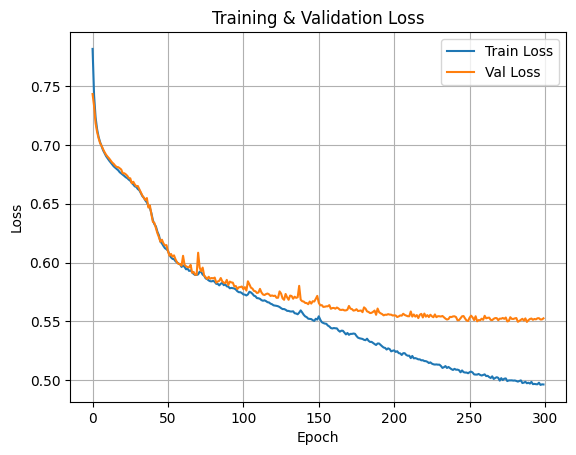

In [ ]:
from piqa import SSIM

class SSIMLoss(SSIM):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def forward(self, x, y):
        return 1. - super().forward(x, y)

model = UNet(1, 1)
loss_fn = SSIMLoss(n_channels=1).cuda()

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1e-5/1e-4, total_iters=300)
optimizer.zero_grad()

train_loss_history, validation_loss_history = train(
    model,
    train_loader,
    validation_loader,
    loss_fn,
    optimizer,
    300,
    accumulation_steps=4,
    device=torch.device("cuda"),
    scheduler=scheduler,
)

plot_loss(train_loss_history, validation_loss_history)
plot_test_results(model, test_loader, device=torch.device("cuda"))